# *** Note that ***
# To run this notebook, you need GPU

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preporcessing
import re
from sklearn.model_selection import train_test_split

# model
from transformers import DistilBertTokenizer, DistilBertModel
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# Import train and test data

In [2]:
#学習用データと評価用データの読み込み
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [3]:
#データのサイズ確認
print(train.shape)
print(test.shape)

(1516, 3)
(1517, 2)


In [4]:
#学習用データの中身を確認
train.head()

,id,description,jobflag
0,0,<li>Develop cutting-edge web applications that...,3
1,1,"<li> Designs and develops high quality, scalab...",3
2,2,<li>Functions as a point person for Network St...,4
3,3,"<li> Work on the technical design, development...",3
4,4,<li>Quantify the resources required for a task...,4


In [5]:
#評価用データの中身を確認
test.head()

,id,description
0,1516,<li>Building decision-making models and propos...
1,1517,<li>Educate homeowners on the benefits of sola...
2,1518,"<li><span>Design, develop, document, and imple..."
3,1519,<li>Apply advanced technical expertise and ski...
4,1520,<li>Project manage and deliver against our roa...


In [6]:
# import random
# random.seed(2)
# for ele in range(20//4):
#     print([random.randint(0, 20) for k in range(4)])

# Preprocessing

In [7]:
import random
random.seed(2)
def augmentation(data):
    tmp_data = data.copy()
    jobflags = []
    descriptions = []
    for i, row in tmp_data.iterrows():
        if (len(row['description']) < 4):
            jobflags.append(row['jobflag'])
            descriptions.append('. '.join(row['description']))
        else:
            num_sentence = len(row['description'])
            for j in range(num_sentence//4):
                ran_index = [random.randint(0, num_sentence-1) for k in range(4)]
                tmp_des = []
                for tmp_index in ran_index:
                    tmp_des.append(row['description'][tmp_index])
                jobflags.append(row['jobflag'])
                descriptions.append('. '.join(tmp_des))

    ret_data = pd.DataFrame(list(zip(jobflags, descriptions)), columns=['jobflag', 'description'])
    return ret_data

In [8]:
#以下の手順でdescriptionデータのクリーニングを行う.
# <li>などのhtmlタグを削除する

def cleaning_train(data):
    tmp_data = data.copy()
    clean_texts = []
    for text in tmp_data["description"]:
        # htmlタグを削除
        text = remove_tag_train(text)
        # replace duble space with single space
        text = ' '.join(text.split()) 
        text = text.replace('\n', '.')
        text = text.replace('. ', '')
        text = text.split('.')
        text = list(filter(lambda x: x != '', text))
        clean_texts.append(text)
        
    tmp_data["description"] = clean_texts
    tmp_data["jobflag"] += -1
    
    ret_data = augmentation(tmp_data)
    
    return ret_data

def cleaning_valid(data):
    tmp_data = data.copy()
    clean_texts = []
    for text in tmp_data["description"]:
        # htmlタグを削除
        text = remove_tag(text)
        # replace duble space with single space
        text = text.replace('  ', ' ')
        
        clean_texts.append(text)
    tmp_data["description"] = clean_texts
    tmp_data["jobflag"] += -1
    return tmp_data

def cleaning_test(data):
    tmp_data = data.copy()
    clean_texts = []
    for text in tmp_data["description"]:
        # htmlタグを削除
        text = remove_tag(text)
        # replace duble space with single space
        text = ' '.join(text.split()) 
        text = text.replace('\n', '.')
        text = text.replace('. ', '')
        text = text.split('.')
        text = list(filter(lambda x: x != '', text))
        clean_texts.append(text)
        
    tmp_data["description"] = clean_texts
    return tmp_data

def remove_tag_train(x):
    p = re.compile(r"<[^>]*?>")
    return p.sub('.',x)

def remove_tag(x):
    p = re.compile(r"<[^>]*?>")
    return p.sub(' ',x)

In [9]:
# #学習用データを分割して, 投稿前の精度検証を行う
raw_train, raw_valid = train_test_split(train, stratify=train['jobflag'], test_size=0.1, random_state=0)

In [37]:
data_train = cleaning_train(raw_train)
data_valid = cleaning_valid(raw_valid)
data_all_train = cleaning_train(train)
data_test = cleaning_test(test)

In [11]:
# for e in raw_train['description']:
#     print(e + "***")

In [12]:
# for e in data_train['description']:
#     print(e)
# #     for sentence in e:
# #         print(sentence+ "** ")
#     print('-------------')

In [13]:
# for e in data_valid['description']:
#     print(e)
# #     for sentence in e:
# #         print(sentence+ "** ")
#     print('-------------')

In [14]:
# import statistics
# train_sentence_length = list(map(lambda x: len(x), data_train['description']))
# test_sentence_length = list(map(lambda x: len(x), data_test['description']))
# print("train mean: {} test mean: {}".format(statistics.mean(train_sentence_length), statistics.mean(test_sentence_length)))
# print("train median: {} test median: {}".format(statistics.median(train_sentence_length), statistics.median(test_sentence_length)))
# #可視化
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# ax.violinplot([train_sentence_length, test_sentence_length])
# ax.set_xticks([1, 2])
# ax.set_xticklabels(['train', 'test'])
# ax.set_ylabel('sentence count')
# plt.savefig('./results/sentence_analysis.png')
# plt.show()

In [15]:
# # クリーニング結果の確認
# print('#original\n', raw_train['description'][1])
# print("-----")
# print('#cleaned\n', data_train['description'][1])

In [16]:
print(train['description'].shape)
print(data_train['description'].shape)
print(data_train['jobflag'].head())

(1516,)
(1829,)
0    0
1    2
2    0
3    0
4    2
Name: jobflag, dtype: int64


# Model

before using transformers, install transformers from huggingface  
`conda install -c huggingface transformers`

In [17]:
# hyper-parameters
epochs = 20
batch_size = 128
max_length = 512

In [18]:
class BertDataset(Dataset):
    def __init__(self, data, tokenizer, max_length, training):
        super(BertDataset, self).__init__()
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.training = training
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        txt = self.data["description"].iloc[index] 
        
        inputs = self.tokenizer.encode_plus(
            txt, 
            None,
            max_length=self.max_length,
            padding='max_length',
            add_special_tokens=True,
            return_attention_mask=True,
            truncation=True,
            return_tensors="pt",
        )
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        if self.training:
            target = torch.tensor(self.data["jobflag"].iloc[index])
            target = F.one_hot(target, num_classes=4).float()
            return ids, mask, target 
        else:
            return ids, mask 

In [19]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [20]:
train_dataset = BertDataset(data_train, tokenizer, max_length=max_length, training=True) 
train_dataloader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)

In [21]:
valid_dataset = BertDataset(data_valid, tokenizer, max_length=max_length, training=True) 
valid_dataloader = DataLoader(dataset=valid_dataset, shuffle=True, batch_size=batch_size)

In [22]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
#         self.fc = nn.Linear(768, 768)
        self.final_layer = nn.Linear(768, 4)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, ids, mask): #, token_type_ids
        out_bert = self.bert(ids, attention_mask=mask, return_dict=False) # , token_type_ids=token_type_ids
#         out = self.fc(out_bert[0][:,0,:])
#         out = self.final_layer(out+out_bert[0][:,0,:]) # skipping connection
        out = self.final_layer(out_bert[0][:,0,:])
        out = self.softmax(out)
        
        return out

# Loss function

In [23]:
# Focal loss

def focal_loss(alpha, gamma=2.0, reduction="none"):
#     alpha= 0.25,
#     gamma: float = 2,
#     reduction: str = "none",

    """
    Original implementation from https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py .
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.

    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha: (optional) Weighting factor in range (0,1) to balance
                positive vs negative examples or -1 for ignore. Default = 0.25
        gamma: Exponent of the modulating factor (1 - p_t) to
               balance easy vs hard examples.
        reduction: 'none' | 'mean' | 'sum'
                 'none': No reduction will be applied to the output.
                 'mean': The output will be averaged.
                 'sum': The output will be summed.
    Returns:
        Loss tensor with the reduction option applied.
    """        
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    gamma =  torch.tensor(gamma, device=device)
    def categorical_focal_loss(inputs, targets):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        epsilon = 1e-10
        epsilon = torch.tensor(epsilon, device=device)
        inputs = inputs.to(device)
        targets = targets.to(device)
        ce_loss = -targets * torch.log(inputs+epsilon)
        loss = alpha * torch.pow(1 - inputs, gamma) * ce_loss #ce_loss * ((1 - p_t) ** gamma)

        if reduction == "mean":
            loss = loss.mean()
        elif reduction == "sum":
            loss = loss.sum()

        return loss
    
    return categorical_focal_loss

In [24]:
# calculate alpha
alpha = len(train) / train['jobflag'].value_counts()
alpha = alpha.sort_index()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alpha = torch.tensor(alpha.values, device=device)
# alpha = alpha / sum(alpha)
print(alpha.shape)
print(alpha)

torch.Size([4])
tensor([ 3.2393, 17.2273,  3.3319,  3.0020], device='cuda:0',
       dtype=torch.float64)


In [25]:
model = BERT()
loss_fn = nn.CrossEntropyLoss()
# loss_fn = focal_loss(alpha=alpha, reduction="sum") # default (gamma = 2.0) gamma=0.5,
optimizer = optim.AdamW(model.parameters())

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
# print(model)

In [27]:
# print(model.bert.transformer.layer[5].ffn)

In [28]:
# if we don't want to re-train bert parameters (we want to train only the last layer)
for param in model.bert.parameters():
    param.requires_grad = False

for param in model.bert.transformer.layer[5].ffn.parameters():
    param.requires_grad = True
# print(model.bert.pooler.parameters())

In [29]:
# To visualize the process of training
def visuzlize_training_process(train_losses, train_accs, val_losses, val_accs):
    #　graph for checking accuracy
    plt.figure(figsize=(10,5))
    plt.plot(train_accs, label = 'train_acc')
    plt.plot(val_accs, label = 'val_acc')
    plt.xticks(np.arange(1, epochs+1, 1))
    plt.title('Accuracy Graph')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig('./results/distilbert_epoch_20_acccuracy.png')
    plt.show()
    plt.close()

    #　graph for checking loss
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label = 'train_loss')
    plt.plot(val_losses, label = 'val_loss')
    plt.xticks(np.arange(1, epochs+1, 1))
    plt.title('Loss Graph')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.savefig('./results/distilbert_epoch_20_loss.png')
    plt.show()
    plt.close()

In [30]:
# To evaluate validation loss and accuracy in training loop
def caluculate_val_loss_acc(model, loss_fn, valid_dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    val_loss = 0.0
    val_correct = 0.0
    with torch.no_grad():
        for ids, mask, target in tqdm(valid_dataloader): #token_type_ids,
            ids = torch.reshape(ids, (ids.shape[0], ids.shape[2]))
            mask = torch.reshape(mask, (mask.shape[0], mask.shape[2]))
            
            ids = ids.to(device)
            mask = mask.to(device)
            
            output = model(ids=ids, mask=mask) 
            loss = loss_fn(output.cpu(), target)
            
            # calculate valid loss and accuracy
            # convert one-hot to label
            val_loss += loss.item() 
            val_pred = torch.argmax(output.cpu(), dim=-1)
            target_label = torch.argmax(target, dim=-1)
            val_correct += torch.sum(val_pred == target_label) 
            
        val_loss = val_loss / len(valid_dataloader.dataset)
        val_acc = val_correct / len(valid_dataloader.dataset)
            
    return val_loss, val_acc

In [31]:
# This function is for training loop
def train_model(epochs, train_dataloader, valid_dataloader, model, loss_fn, optimizer):
    # If you can use GPU, set up GPU. Otherwise, use CPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        print("-----------------------------------")
        
        train_loss = 0.0
        train_correct = 0.0
        for ids, mask, target in tqdm(train_dataloader): 
            # We need to reshape data here, I dont know why
            ids = torch.reshape(ids, (ids.shape[0], ids.shape[2]))
            mask = torch.reshape(mask, (mask.shape[0], mask.shape[2]))
            
            # send data to GPU
            ids = ids.to(device)
            mask = mask.to(device)
            target = target.to(device)
            
            # train and backforward
            optimizer.zero_grad()
            output = model(ids=ids, mask=mask) 
            loss = loss_fn(output, target) 
            loss.backward()
            optimizer.step()
            
            # calculate train loss and accuracy
            # convert one-hot to label
            train_loss += loss.item() 
            train_pred = torch.argmax(output, dim=-1)
            target_label = torch.argmax(target, dim=-1)
            train_correct += torch.sum(train_pred == target_label) 
            
        train_loss = train_loss / len(train_dataloader.dataset)
        train_acc = train_correct / len(train_dataloader.dataset)
        val_loss, val_acc = caluculate_val_loss_acc(model, loss_fn, valid_dataloader)
        
        print("Train Loss: {:.4f} Train Acc: {:.4f}".format(train_loss, train_acc))
        print("Valid Loss: {:.4f} Valid Acc: {:.4f}".format(val_loss, val_acc))
        train_losses.append(train_loss)
        train_accs.append(train_acc.cpu())
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    
    visuzlize_training_process(train_losses, train_accs, val_losses, val_accs)        
    return model

Epoch 1/20
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0100 Train Acc: 0.4959
Valid Loss: 0.0151 Valid Acc: 0.6513
Epoch 2/20
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]


Train Loss: 0.0091 Train Acc: 0.6260
Valid Loss: 0.0156 Valid Acc: 0.5658
Epoch 3/20
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0091 Train Acc: 0.6217
Valid Loss: 0.0152 Valid Acc: 0.6250
Epoch 4/20
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0088 Train Acc: 0.6676
Valid Loss: 0.0139 Valid Acc: 0.6776
Epoch 5/20
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0086 Train Acc: 0.6894
Valid Loss: 0.0149 Valid Acc: 0.6250
Epoch 6/20
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0085 Train Acc: 0.6976
Valid Loss: 0.0142 Valid Acc: 0.6250
Epoch 7/20
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0085 Train Acc: 0.7069
Valid Loss: 0.0136 Valid Acc: 0.6711
Epoch 8/20
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0084 Train Acc: 0.7059
Valid Loss: 0.0140 Valid Acc: 0.6645
Epoch 9/20
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0086 Train Acc: 0.6802
Valid Loss: 0.0148 Valid Acc: 0.6184
Epoch 10/20
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0085 Train Acc: 0.6993
Valid Loss: 0.0143 Valid Acc: 0.6447
Epoch 11/20
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0083 Train Acc: 0.7184
Valid Loss: 0.0144 Valid Acc: 0.6513
Epoch 12/20
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0083 Train Acc: 0.7239
Valid Loss: 0.0139 Valid Acc: 0.6513
Epoch 13/20
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0083 Train Acc: 0.7250
Valid Loss: 0.0146 Valid Acc: 0.6382
Epoch 14/20
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0082 Train Acc: 0.7469
Valid Loss: 0.0137 Valid Acc: 0.7105
Epoch 15/20
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/it]


Train Loss: 0.0083 Train Acc: 0.7305
Valid Loss: 0.0141 Valid Acc: 0.6776
Epoch 16/20
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0082 Train Acc: 0.7365
Valid Loss: 0.0137 Valid Acc: 0.6974
Epoch 17/20
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]


Train Loss: 0.0082 Train Acc: 0.7474
Valid Loss: 0.0147 Valid Acc: 0.6711
Epoch 18/20
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0082 Train Acc: 0.7507
Valid Loss: 0.0140 Valid Acc: 0.6776
Epoch 19/20
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


Train Loss: 0.0081 Train Acc: 0.7594
Valid Loss: 0.0138 Valid Acc: 0.6908
Epoch 20/20
-----------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

Train Loss: 0.0079 Train Acc: 0.7753
Valid Loss: 0.0131 Valid Acc: 0.6711


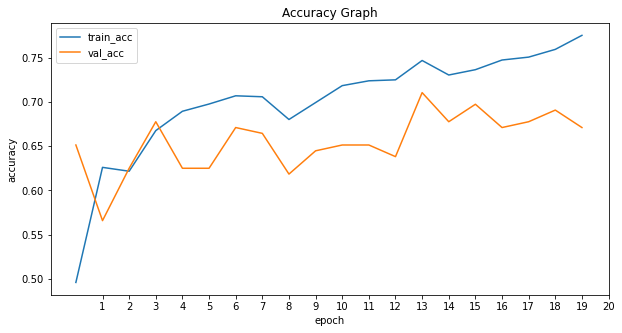

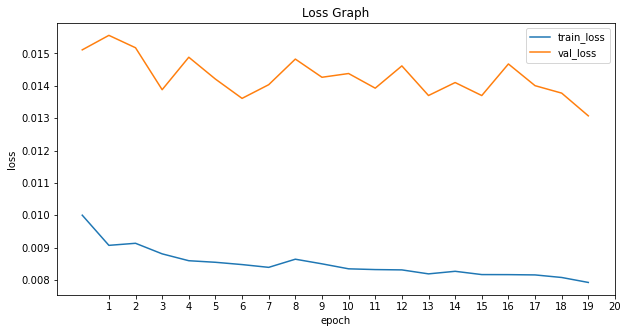

In [32]:
model = train_model(epochs, train_dataloader, valid_dataloader, model, loss_fn, optimizer)

In [33]:
# this is for evaluating model using validation data
def evaluation(model, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    preds = []
    targets = []
    with torch.no_grad():
        for ids, mask, target in tqdm(dataloader):
            ids = torch.reshape(ids, (ids.shape[0], ids.shape[2]))
            mask = torch.reshape(mask, (mask.shape[0], mask.shape[2]))
            
            ids = ids.to(device)
            mask = mask.to(device)
            
            output = model(ids=ids, mask=mask)
            
            pred = torch.argmax(output.cpu(), dim=-1)
            target = torch.argmax(target, dim=-1)
            preds.extend(pred)
            targets.extend(target)
            
    return preds, targets

In [34]:
preds, targets = evaluation(model, valid_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


              precision    recall  f1-score   support

           1      0.582     0.681     0.627        47
           2      0.000     0.000     0.000         9
           3      0.780     0.711     0.744        45
           4      0.679     0.745     0.710        51

    accuracy                          0.671       152
   macro avg      0.510     0.534     0.520       152
weighted avg      0.639     0.671     0.653       152



/home/yoshi/miniconda3/envs/torch-gpu-signate/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yoshi/miniconda3/envs/torch-gpu-signate/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yoshi/miniconda3/envs/torch-gpu-signate/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

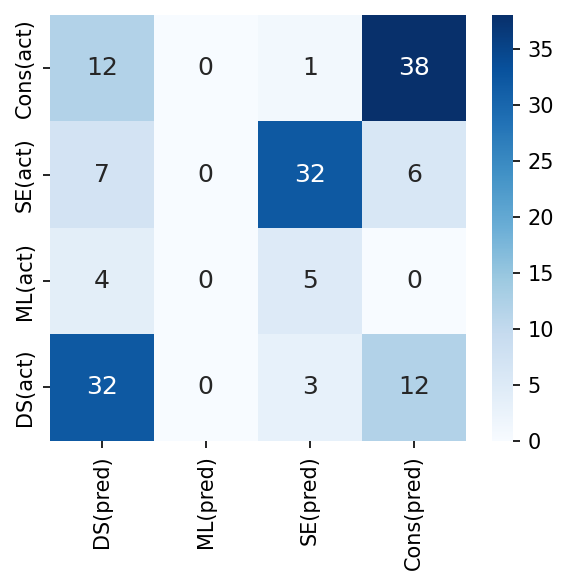

In [35]:
from sklearn.metrics import confusion_matrix, classification_report
labels = [1, 2, 3, 4]
l_preds = list(map(lambda x: x + 1, preds))
l_targets = list(map(lambda x: x + 1, targets))
re_labels = ["DS", "ML", "SE", "Cons"]

#混同行列の作成
conf_mx = confusion_matrix(l_targets, l_preds, labels=labels)
conf_df = pd.DataFrame(data=conf_mx, index=[x + "(act)" for x in re_labels], columns=[x + "(pred)" for x in re_labels])

#可視化
plt.figure(figsize=(4, 4), dpi=150)
sns.heatmap(conf_df, cmap='Blues', annot=True, fmt='d', annot_kws={"size": 12}).invert_yaxis()
plt.tight_layout()
plt.savefig('./results/distilbert_epoch_20_heatmap.png')

print(classification_report(l_targets, l_preds, labels=labels, digits=3))

# Submit 

In [38]:
# train model using all data
submit_dataset = BertDataset(data_all_train, tokenizer, max_length=max_length, training=True) 
submit_dataloader = DataLoader(dataset=submit_dataset, shuffle=True, batch_size=batch_size)

In [39]:
model = BERT()
loss_fn = nn.CrossEntropyLoss()
# loss_fn = focal_loss(alpha=alpha, reduction="sum") # default (gamma = 2.0), gamma=0.5,
optimizer = optim.AdamW(model.parameters())

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
# if we don't want to re-train bert parameters (we want to train only the last layer)
for param in model.bert.parameters():
    param.requires_grad = False

for param in model.bert.transformer.layer[5].ffn.parameters():
    param.requires_grad = True
# print(model.bert.pooler.parameters())

In [44]:
# This function is for training loop
def train_submit_model(epochs, dataloader, model, loss_fn, optimizer):
    # If you can use GPU, set up GPU. Otherwise, use CPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        print("-----------------------------------")
        for ids, mask, target in tqdm(dataloader):
            # We need to reshape data here, I dont know why
            ids = torch.reshape(ids, (ids.shape[0], ids.shape[2]))
            mask = torch.reshape(mask, (mask.shape[0], mask.shape[2]))
            
            # send data to GPU
            ids = ids.to(device)
            mask = mask.to(device)
            target = target.to(device)
            
            # train and backforward
            optimizer.zero_grad()
            output = model(ids=ids, mask=mask)
            loss = loss_fn(output, target) 
            loss.backward()
            optimizer.step()
       
    return model

In [45]:
model = train_submit_model(epochs, submit_dataloader, model, loss_fn, optimizer)

Epoch 1/20
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:31<00:00,  1.94s/it]


Epoch 2/20
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.13s/it]


Epoch 3/20
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.13s/it]


Epoch 4/20
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.13s/it]


Epoch 5/20
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.13s/it]


Epoch 6/20
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.13s/it]


Epoch 7/20
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.13s/it]


Epoch 8/20
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.13s/it]


Epoch 9/20
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.13s/it]


Epoch 10/20
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.13s/it]


Epoch 11/20
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.13s/it]


Epoch 12/20
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.13s/it]


Epoch 13/20
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.13s/it]


Epoch 14/20
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.13s/it]


Epoch 15/20
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.13s/it]


Epoch 16/20
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.13s/it]


Epoch 17/20
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.13s/it]


Epoch 18/20
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.13s/it]


Epoch 19/20
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.13s/it]


Epoch 20/20
-----------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.13s/it]


In [46]:
torch.save(model.state_dict(), './results/distilbert_epoch_20_.pth')

In [47]:
test_dataset = BertDataset(data_test, tokenizer, max_length=max_length, training=False) 
test_dataloader = DataLoader(dataset=test_dataset, shuffle=True, batch_size=batch_size)

In [48]:
def prediction(model, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    preds = []
    with torch.no_grad():
        for ids, mask in tqdm(dataloader):
            ids = torch.reshape(ids, (ids.shape[0], ids.shape[2]))
            mask = torch.reshape(mask, (mask.shape[0], mask.shape[2]))
            
            ids = ids.to(device)
            mask = mask.to(device)
            
            output = model(ids=ids, mask=mask)
            
            pred = torch.argmax(output.cpu(), dim=-1)
            preds.extend(pred.numpy())
            
    return preds

In [49]:
pred_sub = prediction(model, test_dataloader)
pred_sub = list(map(lambda x: x + 1, pred_sub))

100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.95s/it]


In [50]:
sample_submit_df = pd.DataFrame(list(zip(list(test['id'].values), pred_sub)), columns=["id", "pred"])
sample_submit_df.to_csv('../ensemble/distilbert/test.csv', header=None, index=None)